In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

In [6]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [7]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [13]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도','주차대수',
                    'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
                    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
                    'k-135㎡초과', '건축면적','latitude', 'longitude',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

df['계약년월'] = df['계약년월'].astype(np.datetime64)



In [34]:
# 집 유형 나누기

def house_type(x):
    house_type_list = [0, 33.058, 66.116, 99.174, 132.232, 165.29, 198.348, 231.406, 264.464, 297.522, 330.58, 363.638, 396.696, 429.754, 462.812, 495.87]

    for type, size in enumerate(house_type_list):
        if x < size:
            return type
    return 16

df['집유형'] = df['전용면적'].apply(house_type)
df['집유형'] = df['집유형'].astype(int)

In [35]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

In [64]:
for region in regions:
    chunk = chunks[region]
    print(region)

    for dong in chunk['동'].unique():
        cnt = len(chunk.loc[(chunk['is_test'] == 0) & (chunk['동'] == dong)])

        if cnt < 1000:
            print(f"\t{dong} : {cnt}")

강남구
	신사동 : 810
	자곡동 : 838
	율현동 : 106
강동구
강북구
	우이동 : 409
강서구
	공항동 : 343
관악구
광진구
	군자동 : 576
	화양동 : 717
	능동 : 16
구로구
	가리봉동 : 101
	온수동 : 873
	궁동 : 492
	항동 : 413
금천구
노원구
도봉구
동대문구
	신설동 : 154
	회기동 : 871
동작구
	동작동 : 894
	상도1동 : 162
마포구
	노고산동 : 568
	마포동 : 543
	상수동 : 581
	신정동 : 469
	동교동 : 22
	용강동 : 837
	하중동 : 323
	합정동 : 524
	연남동 : 833
	토정동 : 444
	현석동 : 955
	구수동 : 3
서대문구
	냉천동 : 719
	대현동 : 857
	영천동 : 663
	충정로3가 : 667
	창천동 : 281
	천연동 : 963
	충정로2가 : 81
	합동 : 175
	미근동 : 33
서초구
	내곡동 : 610
	신원동 : 603
성동구
	송정동 : 632
	도선동 : 266
	사근동 : 337
	상왕십리동 : 424
	용답동 : 199
	홍익동 : 186
성북구
	동소문동5가 : 152
	동소문동7가 : 526
	보문동3가 : 565
	동선동1가 : 53
	동선동3가 : 24
	동선동4가 : 46
	동선동5가 : 7
	동소문동4가 : 370
	동소문동6가 : 41
	보문동6가 : 521
	보문동4가 : 78
	삼선동3가 : 366
	삼선동4가 : 334
	삼선동5가 : 30
	성북동 : 73
	성북동1가 : 34
	안암동1가 : 482
	안암동3가 : 442
	안암동4가 : 52
	보문동2가 : 15
	안암동5가 : 6
송파구
	석촌동 : 726
	삼전동 : 226
양천구
영등포구
	도림동 : 861
	당산동1가 : 540
	당산동6가 : 70
	문래동2가 : 172
	문래동5가 : 871
	양평동2가 : 986
	문래동4가 : 447
	양평동1가 : 661
	양평동4가 : 687
	양평동6가 : 442
	영등포동8가 : 922

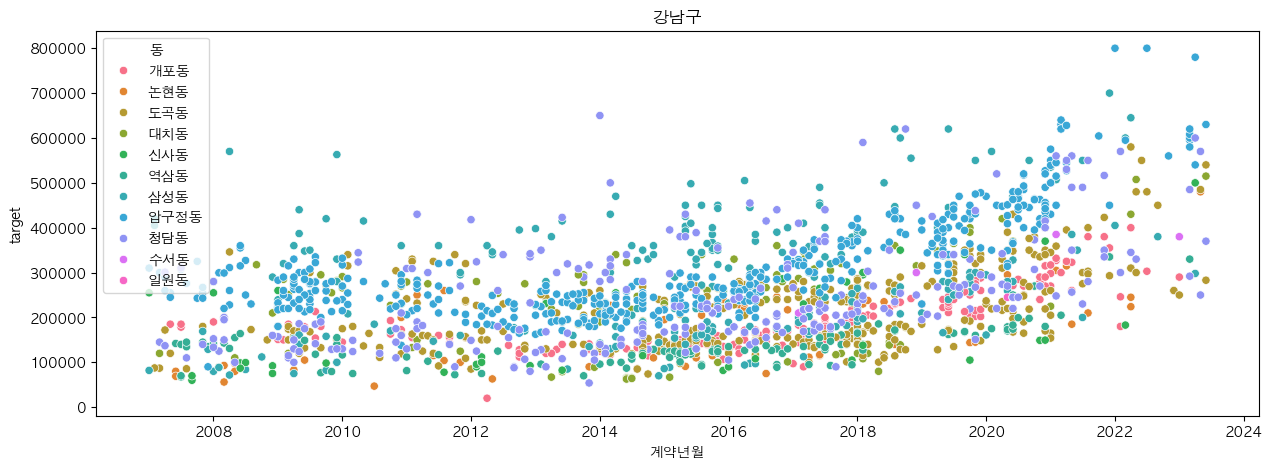

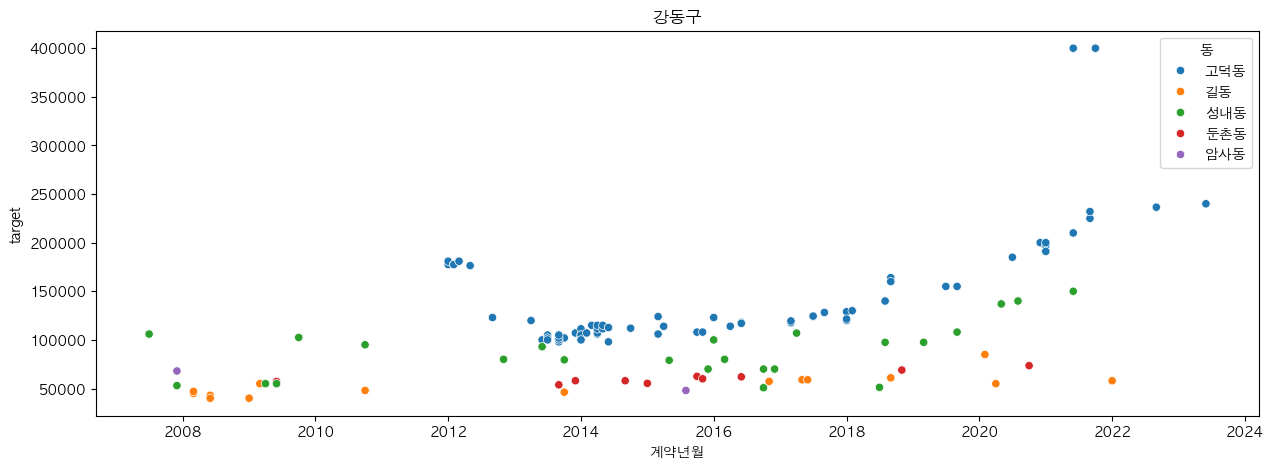

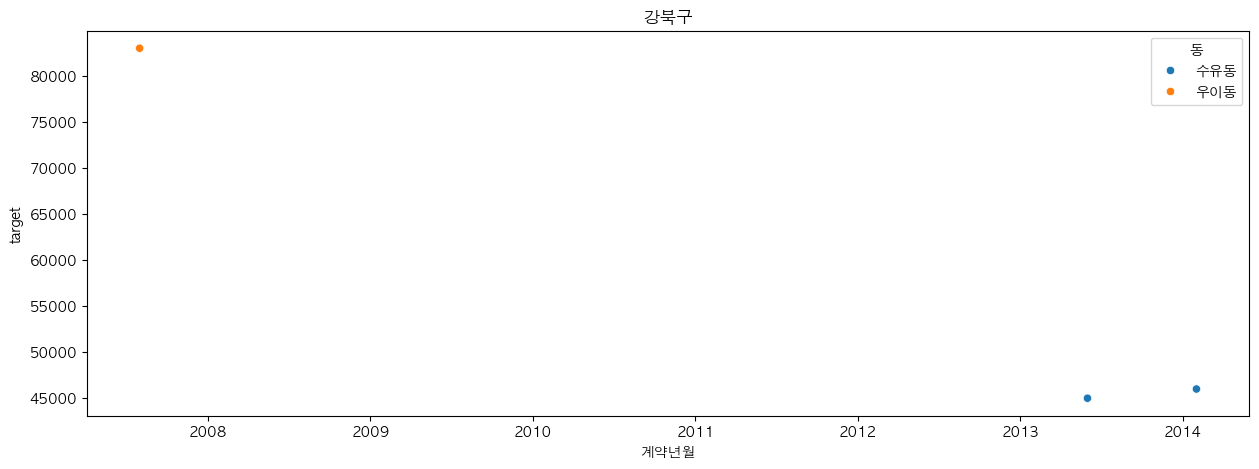

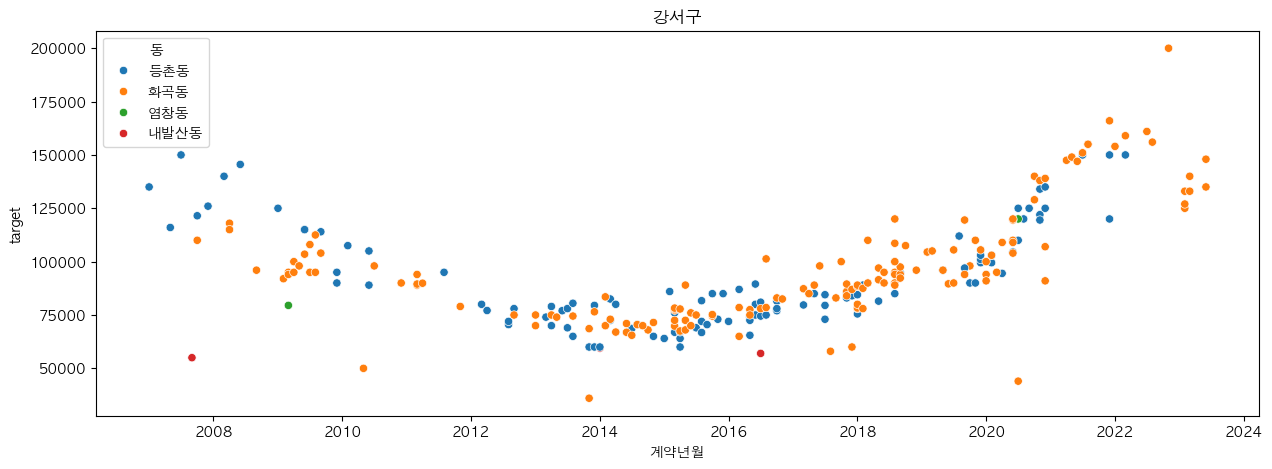

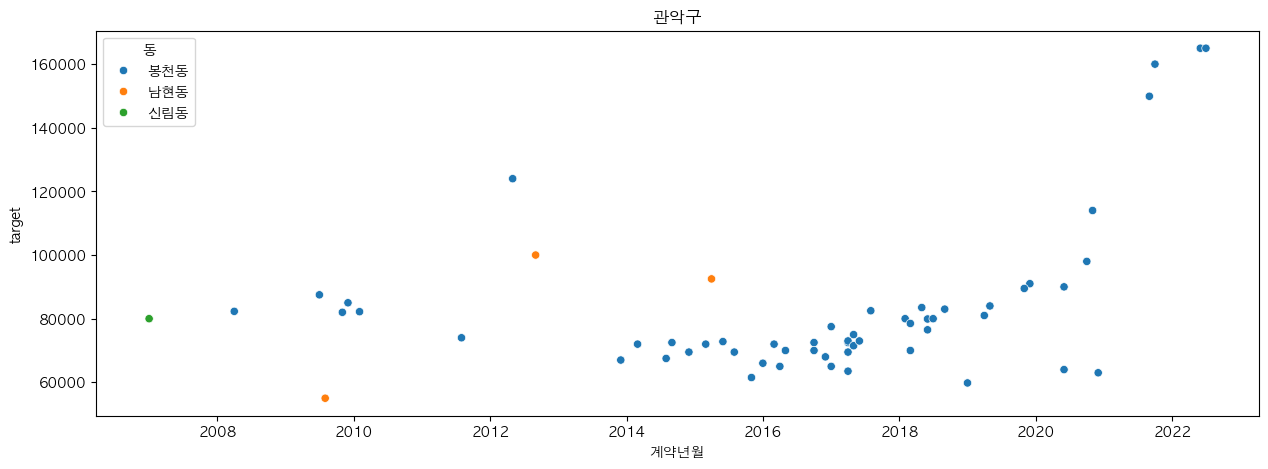

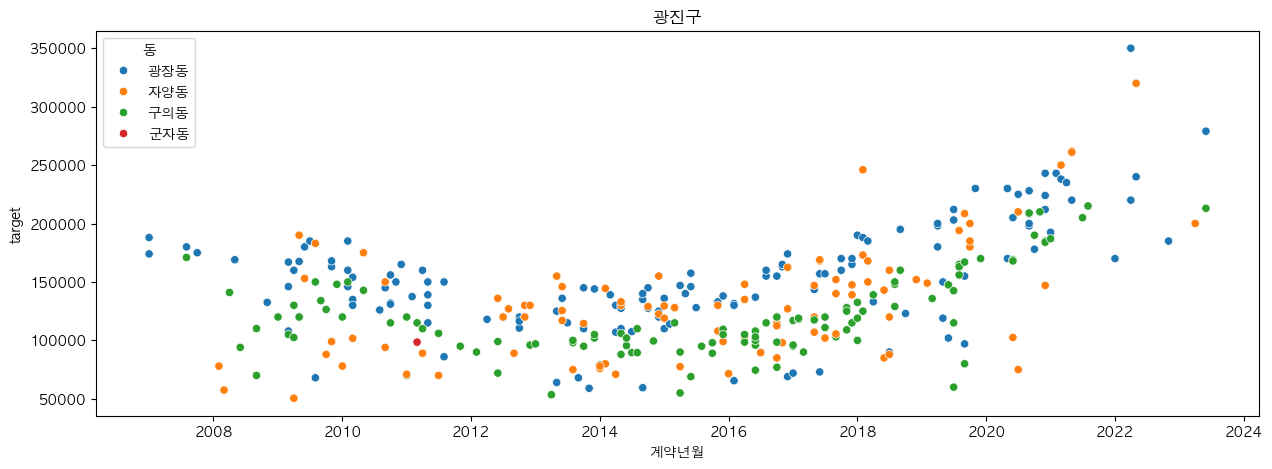

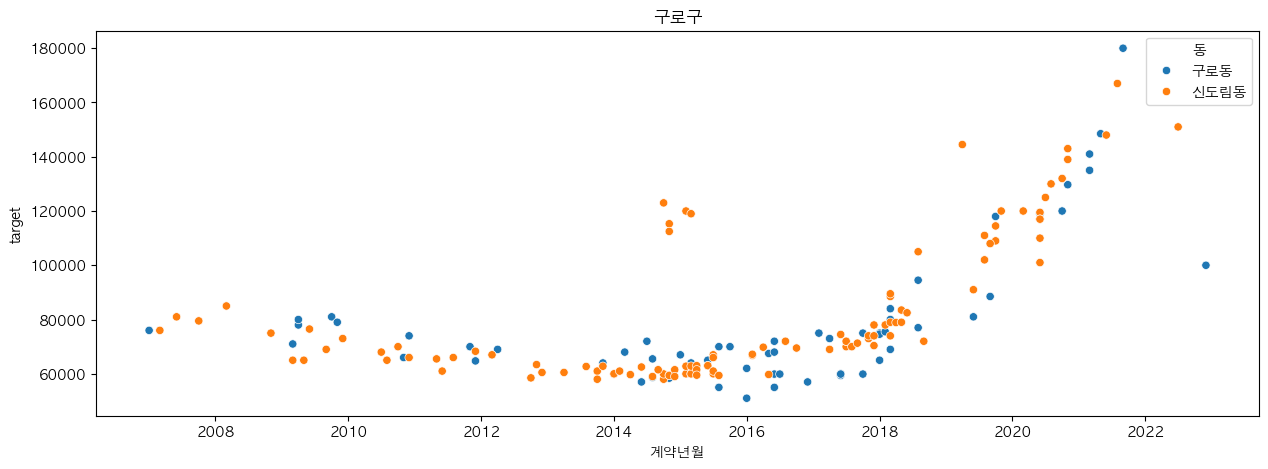

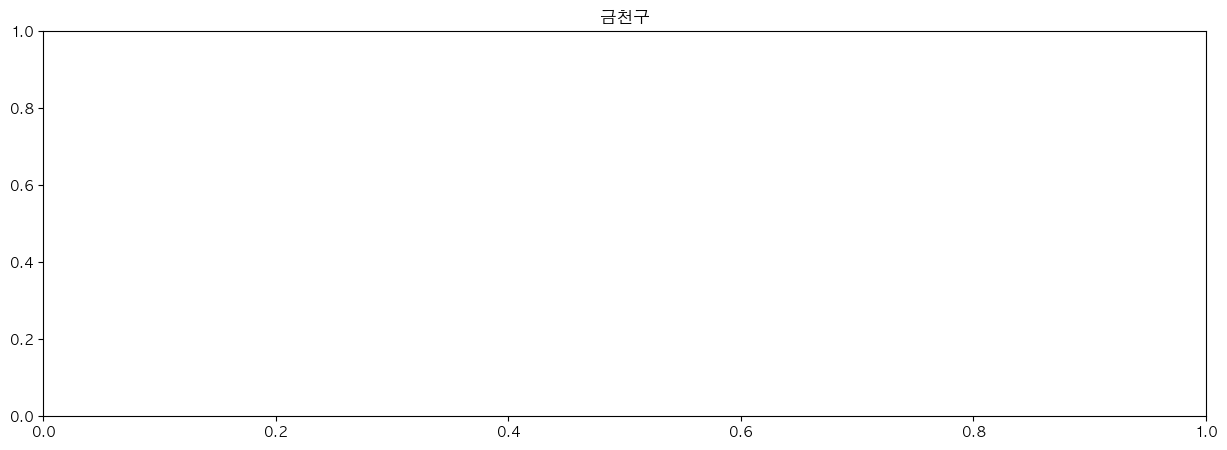

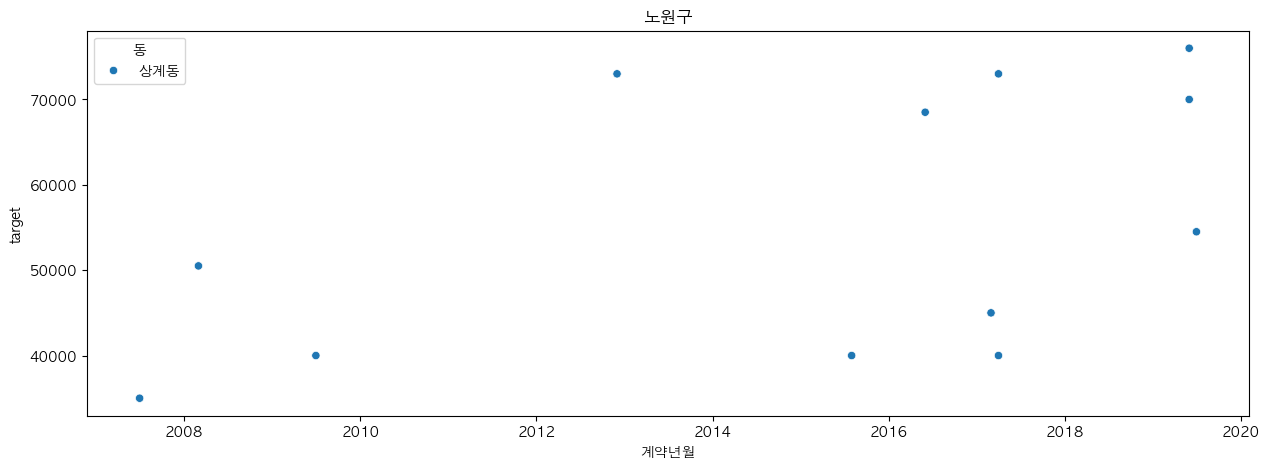

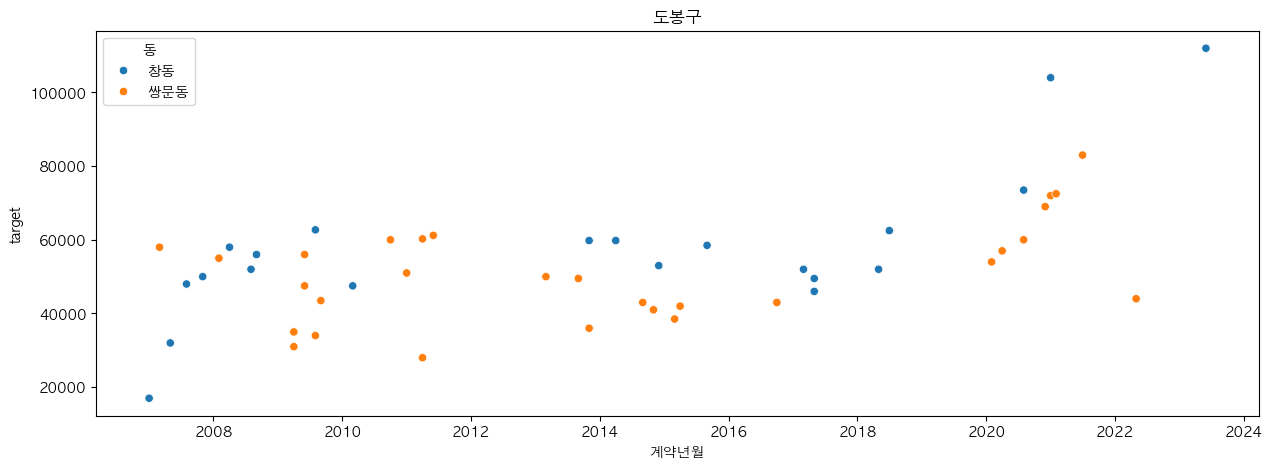

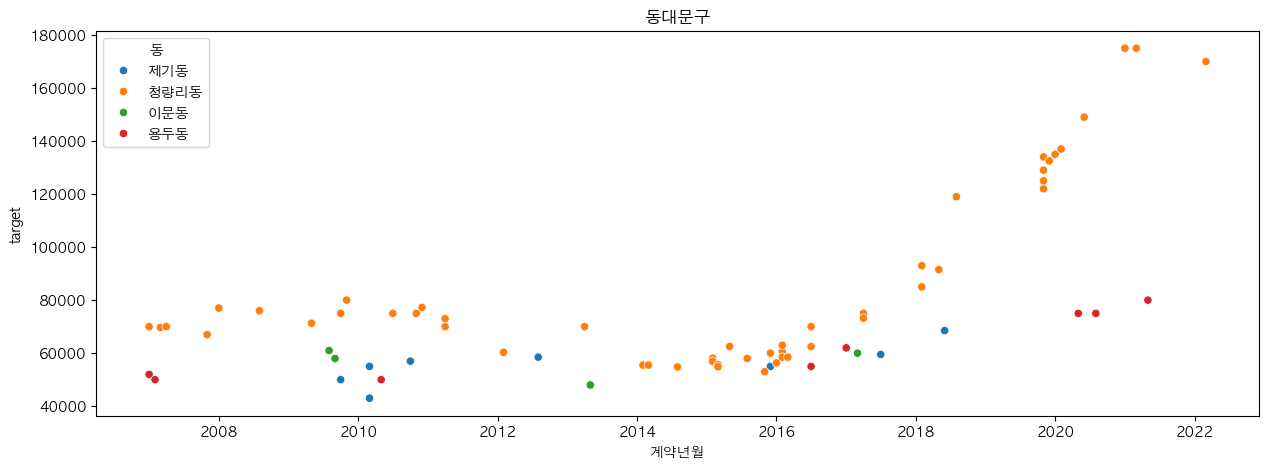

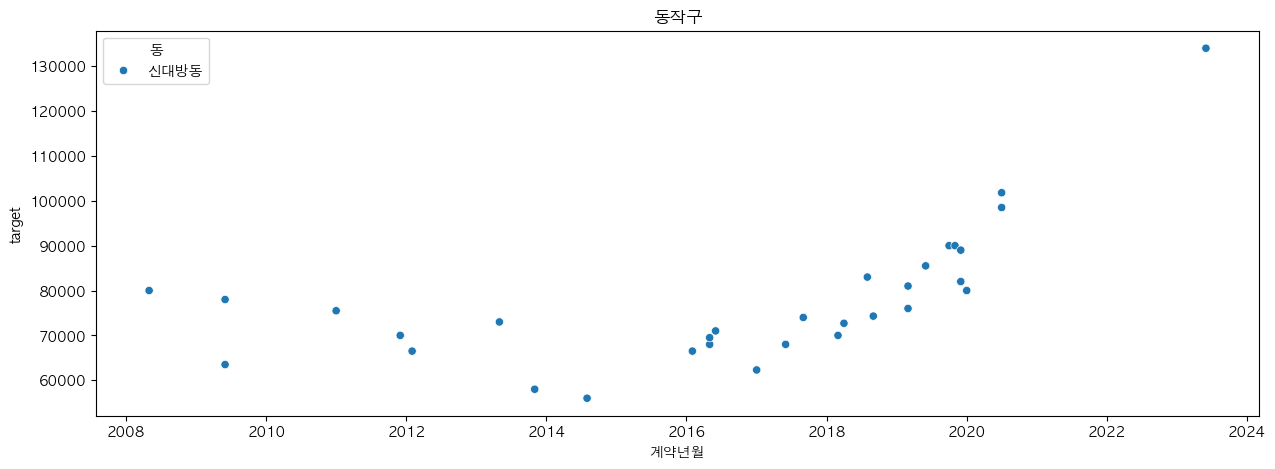

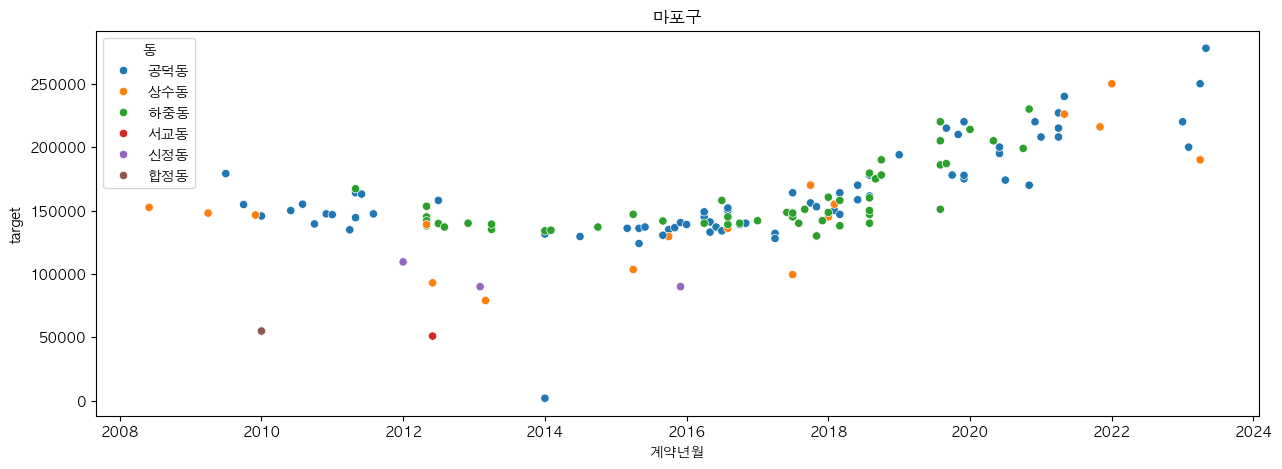

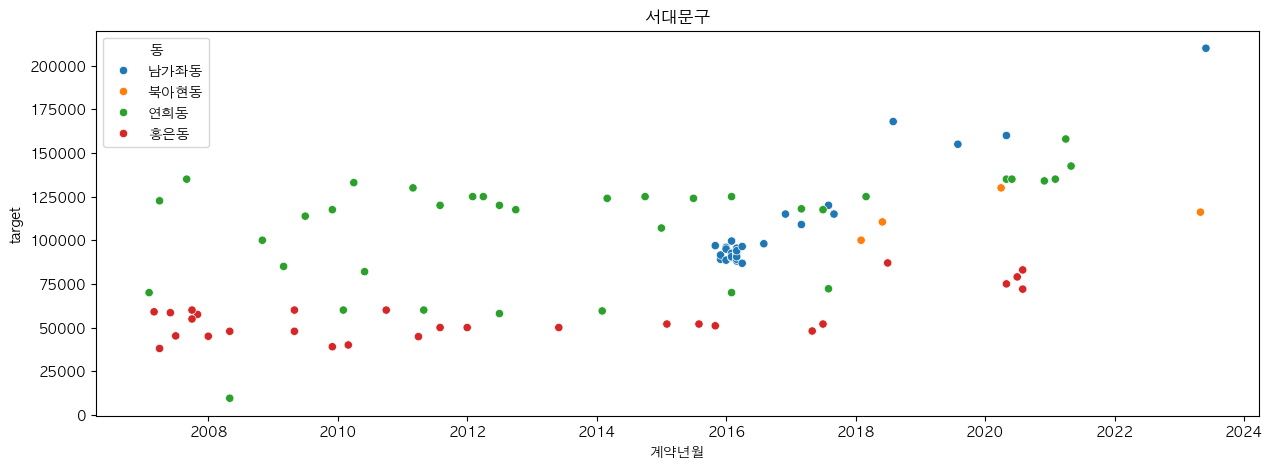

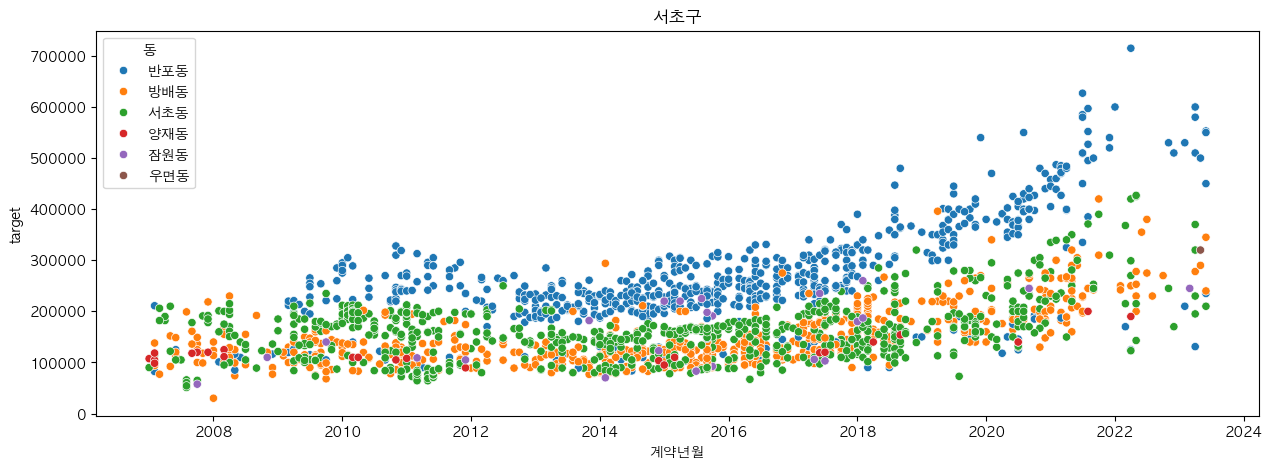

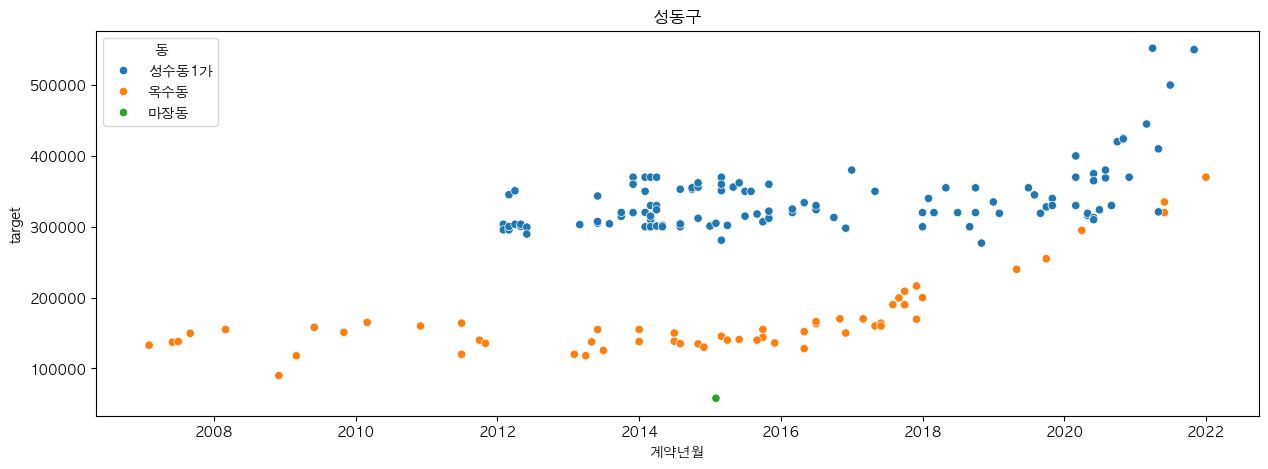

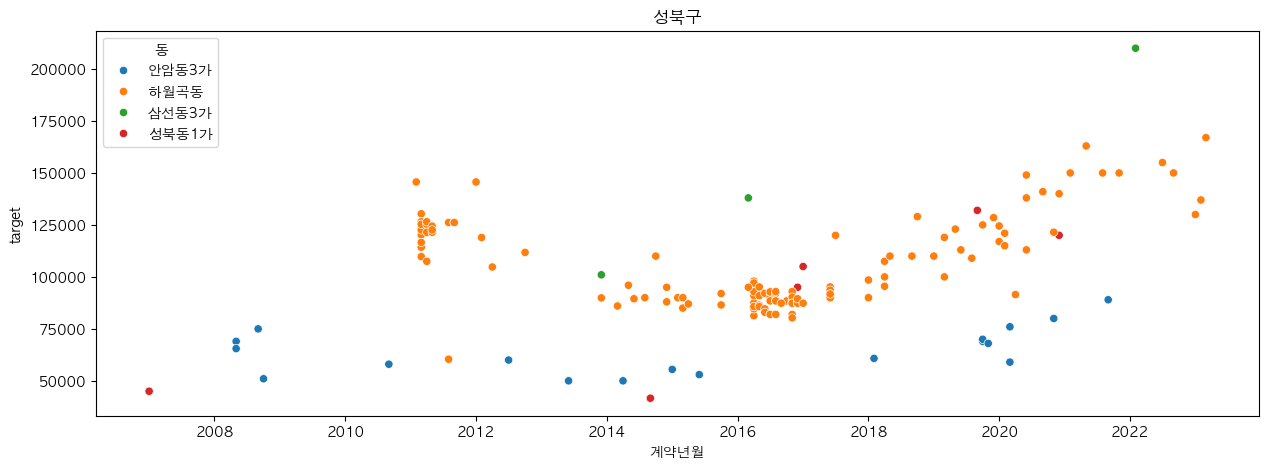

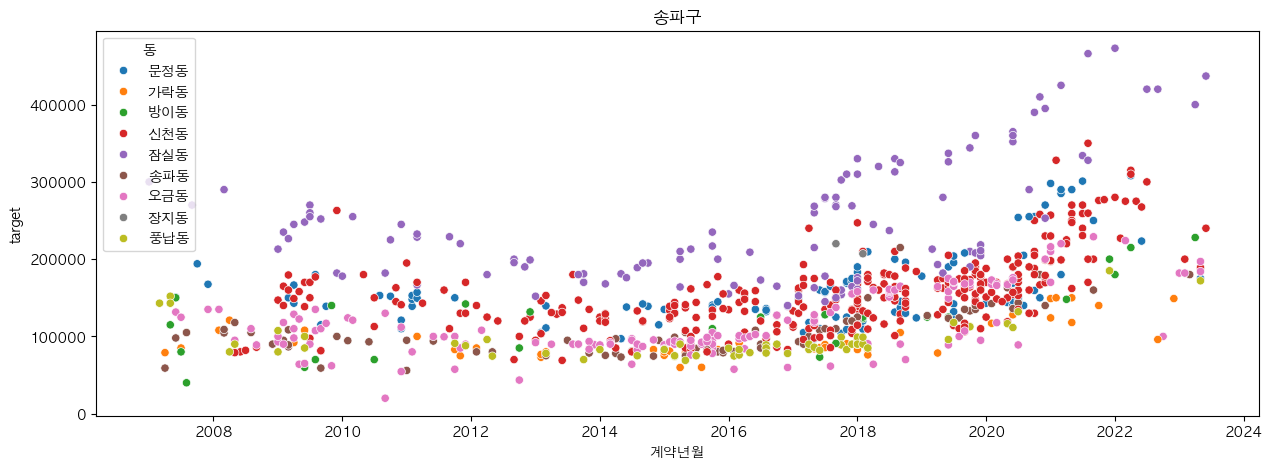

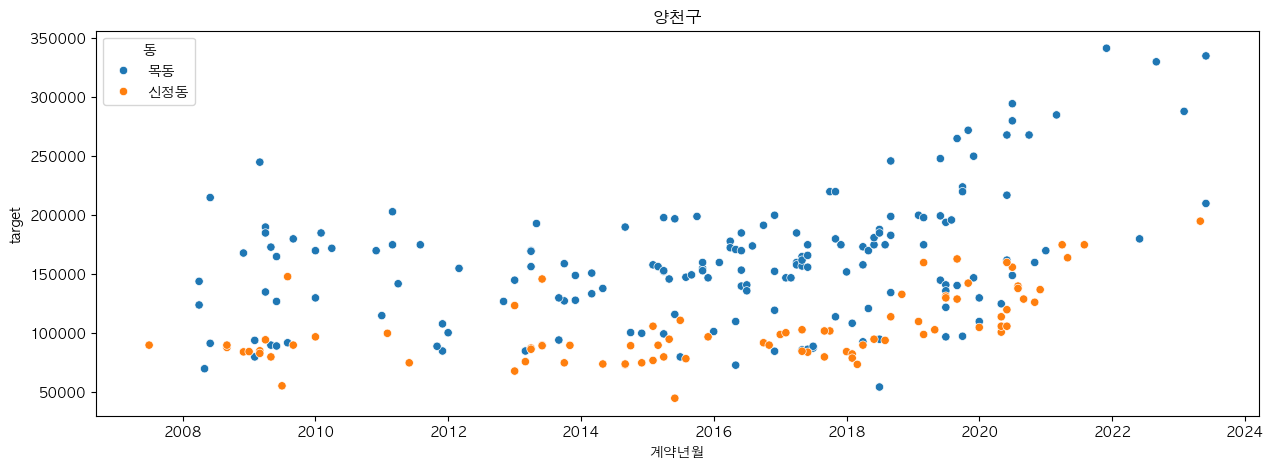

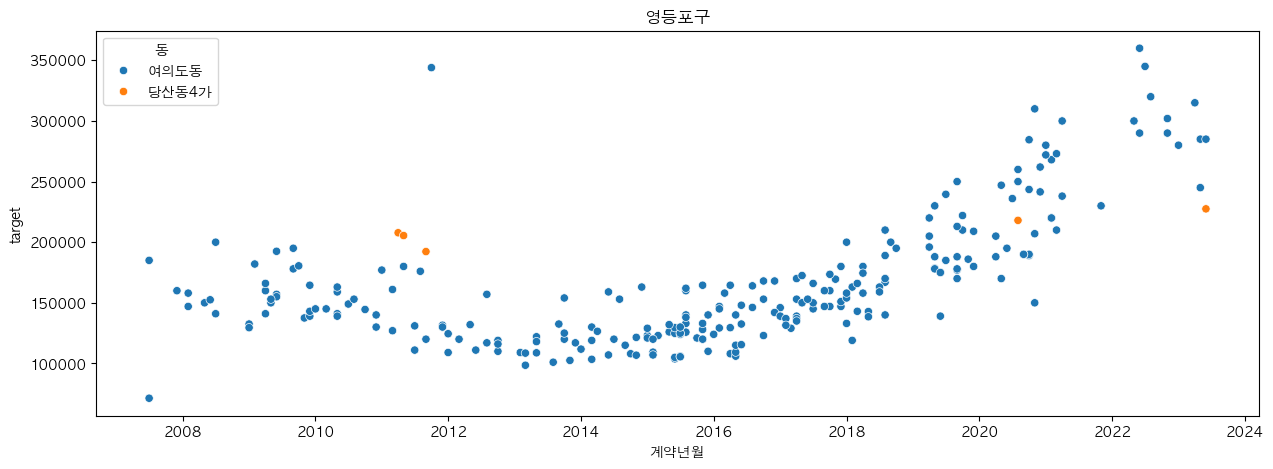

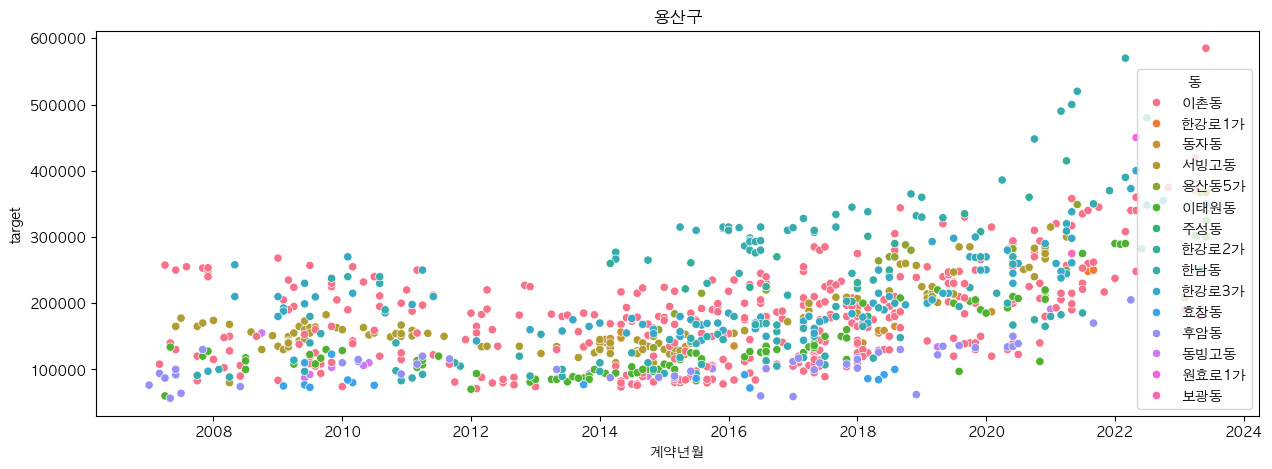

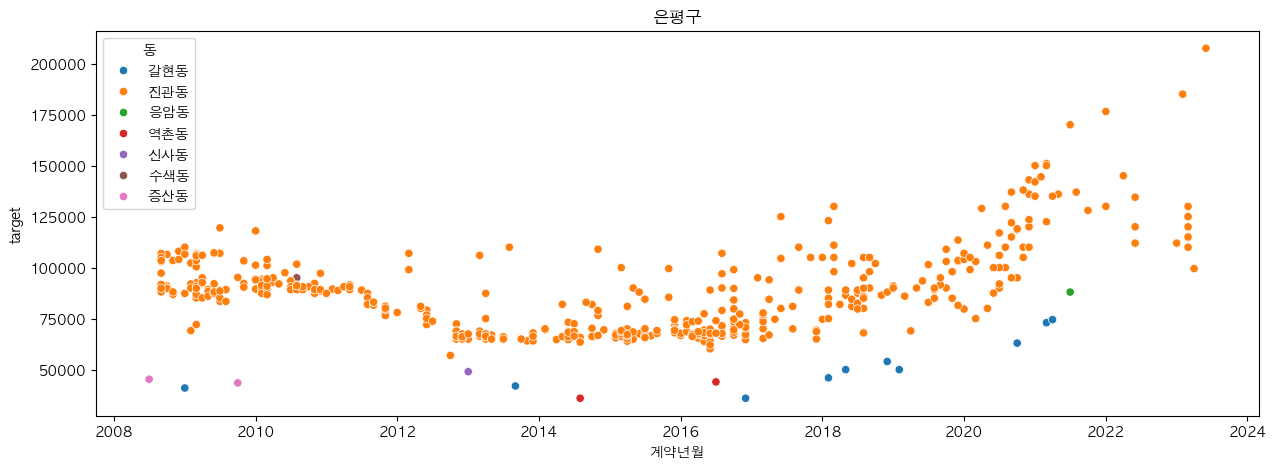

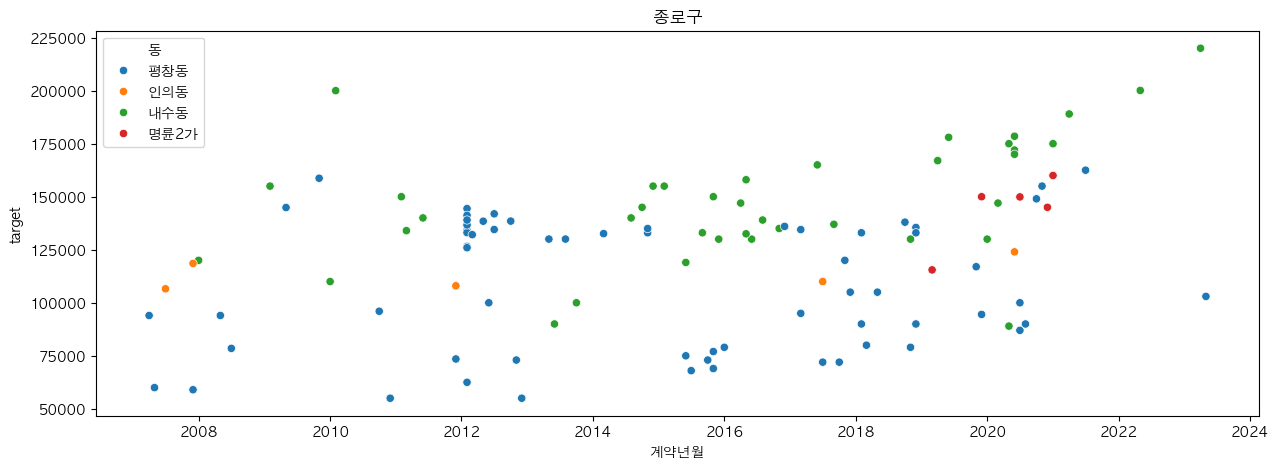

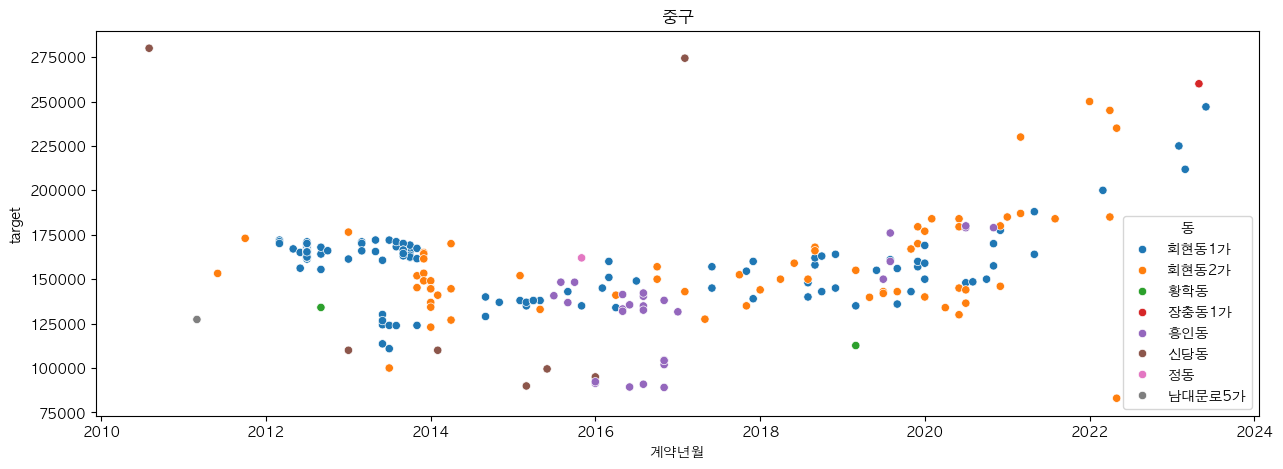

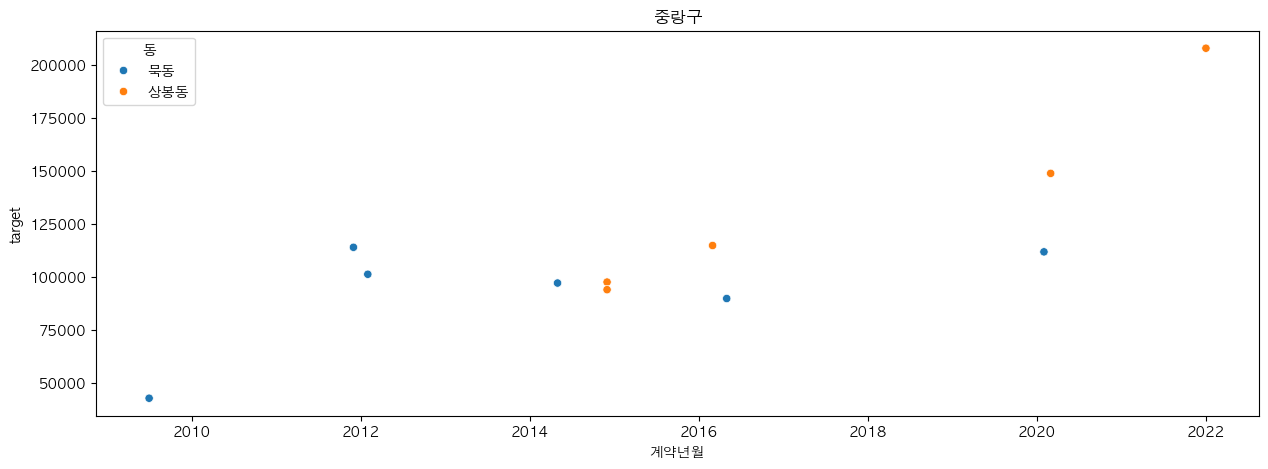

In [60]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

cnt = 0
for region in regions:
    chunk = chunks[region]

    type = 6
    house_type = chunk.loc[(chunk['집유형'] == type) & (chunk['is_test'] == 0)]

    plt.figure(figsize=(15,5))
    plt.title(region)
    sns.scatterplot(data=house_type, x = '계약년월', y='target', hue='동')
        
    

# 앞뒤 3개월을 보고 IQR에 벗어난 것들 outlier 취급

In [55]:
def check_outlier(sample, region_data):
    target = sample['target']
    house_type = sample['집유형']
    
    dong = sample['동']
    region_data = region_data[region_data['동'] == dong]

    contract_date = pd.to_datetime(sample['계약년월'])
    start_date = contract_date - pd.DateOffset(months=3)
    end_date = contract_date + pd.DateOffset(months=3)

    temp_data = region_data[(region_data['계약년월'] >= start_date) & (region_data['계약년월'] <= end_date)]
    house_type_df = temp_data[temp_data['집유형'] == house_type]

    Q1 = house_type_df['target'].quantile(0.25)
    Q3 = house_type_df['target'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    is_outlier = (target < lower_bound) or (target > upper_bound)
    
    return is_outlier

# 모델 학습

In [ ]:
for region in regions:
    chunk = chunks[region]

    chunk = chunk[chunk['is_outlier'] == False]
    chunks[region] = chunk

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()
trained_models = {}

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id', '전용면적', '계약일', '층', '건축년도','주차대수',
                    'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
                    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
                    'k-135㎡초과', '건축면적','latitude', 'longitude',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target',
                    'apt_mean_target', 'mean_target','올해 지역 평균', '작년 지역 평균']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                inti_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            inti_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )
    
    trained_models[region] = final_model

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


# 결과확인

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_remove_outlier(2).csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()